In [42]:
 # %%
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, get_gradient_colors
from utils.opto_utils import opto_metrics
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import spikeinterface.widgets as sw
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from trimesh import load_mesh
from utils.ccf_utils import ccf_pts_convert_to_mm
%matplotlib inline


In [34]:
session = 'behavior_754897_2025-03-13_11-20-42'
data_type = 'curated'
target = 'soma'


In [35]:

session_dir = session_dirs(session)
unit_tbl = get_unit_tbl(session, data_type, summary=True)
we = si.load(session_dir['postprocessed_dir_curated'], load_extensions=False)
y_loc = we.get_extension('unit_locations').get_data()[:,1]


In [ ]:

#     # %%
# unit_tbl = get_unit_tbl(session, data_type, summary=False)
# opto_tag = opto_metrics(session, data_type)
# unit_ids = unit_tbl['unit_id'].values.tolist()
# unit_ids = [int(unit_id) for unit_id in unit_ids]

# # %%
# p_max = []
# p_mean = []
# lat_max_p = []
# lat_mean = []
# euc_max_p = []
# corr_max_p = []
# bl_max_p = []
# pass_count = [] 
# # check if this session has a unit opto tagged at all by checking if resp_lat exists
# for unit_id in unit_ids:
#     curr_opto = opto_tag.load_unit(unit_id)
#     # find ones with respond latencies
#     sort_inds = np.argsort(curr_opto['resp_p_bl'].values)[::-1]
#     for curr_ind in sort_inds:
#         curr_max_p = curr_opto['resp_p_bl'].values[curr_ind]
#         if not curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].isna().all():
#             break
#     if curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].isna().all():
#         curr_max_p = curr_opto['resp_p_bl'].max()

#     p_max.append(curr_max_p)
#     p_max_ind = curr_opto['resp_p_bl'].idxmax()
#     max_conditions = curr_opto[curr_opto['resp_p_bl']==curr_max_p]
#     # count number of cases that passes the threshold, group by power, pre-post and duration
#     count = curr_opto.groupby(['powers', 'stim_times', 'durations']).agg({'resp_p_bl': list})
#     count = count.reset_index()
#     count = pd.DataFrame(count)
#     count_curr_all = []
#     for row in count.iterrows():
#         count_curr = np.sum(np.array(row[1]['resp_p_bl']) >= 0.3)
#         count_curr_all.append(count_curr)
#     pass_count.append(np.max(count_curr_all))

#     p_mean.append(np.nanmax(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['mean_p'].values))

#     lat_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].values))
#     lat_mean.append(curr_opto['resp_lat'].mean(skipna=True))
#     if np.all(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values == None):
#         euc_max_p.append(np.nan)
#         corr_max_p.append(np.nan)
#     else:
#         euc_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values))
#         corr_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['correlation'].values))
#     bl_max_p.append(curr_opto.loc[p_max_ind]['resp_p'] - curr_opto.loc[p_max_ind]['resp_p_bl'])
# peak_channel = [np.argmax(np.abs(temp[90,:])) for temp in unit_tbl['waveform_mean']]
# peak_index = [np.argmin(temp[:, peakC]) for temp, peakC in zip(unit_tbl['waveform_mean'], peak_channel)]
# peak_wf = [temp[90-30:90+60, peak_C] for temp, peak_C in zip(unit_tbl['waveform_mean'], peak_channel)]
# peak_wf_aligned = [
#     np.concatenate((
#         np.full(max(30 - peak_ind, 0), np.nan),
#         temp[max(peak_ind - 30, 0) : min(peak_ind + 60, temp.shape[0]), peak_C],
#         np.full(max((peak_ind + 60) - temp.shape[0], 0), np.nan)
#     ))
#     for temp, peak_ind, peak_C in zip(unit_tbl['waveform_mean'], peak_index, peak_channel)
# ]

# amp = [np.max(temp[:, peak_C]) - np.min(temp[:, peak_C]) for temp, peak_C in zip(unit_tbl['waveform_mean'], peak_channel)]
# peak = [temp[90,peak_C] for temp, peak_C in zip(unit_tbl['waveform_mean'], peak_channel)]
# label = unit_tbl['decoder_label'].values
# real_unit = label != 'artifact'
# opto_tag_tbl = pd.DataFrame({'unit_id': unit_ids, 
#                             'bl_max_p': bl_max_p,
#                             'p_max': p_max, 
#                             'p_mean': p_mean, 
#                             'lat_max_p': lat_max_p, 
#                             'lat_mean': lat_mean, 
#                             'euc_max_p': euc_max_p, 
#                             'corr_max_p': corr_max_p, 
#                             'opto_pass': unit_tbl['opto_pass'].values,
#                             'amp': amp, 
#                             'peak': peak,
#                             'real_unit': real_unit,
#                             'y_loc': y_loc, 
#                             'pass_count': pass_count,
#                             })

# unit_tbl_tmp = unit_tbl.copy()
# unit_tbl_tmp.drop(columns=opto_tag_tbl.columns.difference(['unit_id']), inplace=True, errors='ignore')
# unit_tbl_tmp['peak_wf'] = peak_wf
# unit_tbl_tmp['peak_wf_aligned'] = peak_wf_aligned
# unit_tbl_tmp['wf_2d'] = wf_2d
# opto_tag_tbl_summary = pd.merge(opto_tag_tbl, unit_tbl_tmp, on='unit_id')


Text(0.5, 1.0, 'counts')

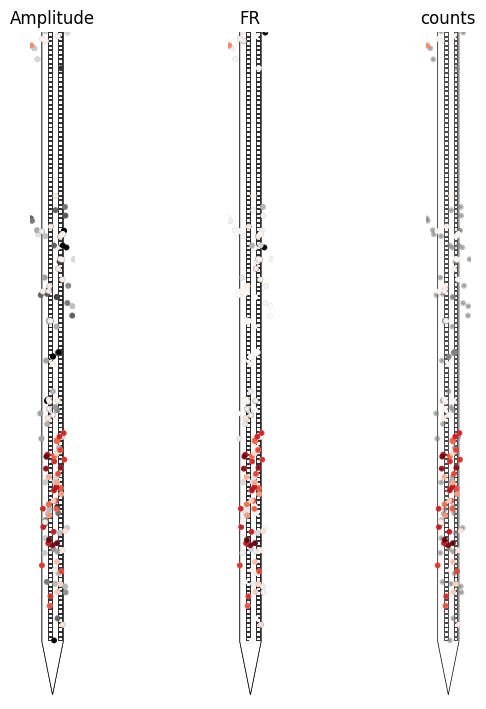

In [36]:
unit_ids = we.sorting.unit_ids
fig = plt.figure(figsize=(20, 10))
gs_probe = gridspec.GridSpec(2, 8, figure=fig, height_ratios=[1, 20])
# amplitude
ax = fig.add_subplot(gs_probe[1, 0])
colors, norm, cmap = get_gradient_colors(unit_tbl['amp'].values, ceiling=200, cmap_name='Grays')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax, hide_axis=True)

unit_ids_filtered = pd.Series(unit_ids)[unit_tbl['real_unit'] & (unit_tbl['lat_mean']>=0.007) & (unit_tbl['euc_max_p']<=0.3)].values.tolist()
colors, norm, cmap = get_gradient_colors(unit_tbl['p_mean'].values, ceiling=0.8, cmap_name='Reds')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax, hide_axis=True)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('Amplitude')

# fr
ax = fig.add_subplot(gs_probe[1, 1])
colors, norm, cmap = get_gradient_colors(unit_tbl['firing_rate'].values, ceiling=20, cmap_name='Grays')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax, hide_axis=True)

unit_ids_filtered = pd.Series(unit_ids)[unit_tbl['real_unit'] & (unit_tbl['lat_mean']>=0.007) & (unit_tbl['euc_max_p']<=0.3)].values.tolist()
colors, norm, cmap = get_gradient_colors(unit_tbl['p_mean'].values, ceiling=0.8, cmap_name='Reds')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax, hide_axis=True)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('FR')

# fr
ax = fig.add_subplot(gs_probe[1, 2])

# w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, ax = ax, hide_axis=True)

unit_ids_filtered = pd.Series(unit_ids)[unit_tbl['real_unit'] & (unit_tbl['lat_mean']>=0.007) & (unit_tbl['euc_max_p']<=0.3)].values.tolist()
colors, norm, cmap = get_gradient_colors(unit_tbl['p_mean'].values, ceiling=0.8, cmap_name='Reds')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax, hide_axis=True)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('counts')


In [107]:
# in ccf space
# load combined_unit_tbl
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units_filtered = combined_tagged_units[combined_tagged_units['session'] == session]
# load mesh
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
mesh_vertices_mm[:, 2] = -np.abs(mesh_vertices_mm[:, 2])  # Mirror ML to left
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
ml, ap, dv = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

In [135]:
animal_id = '751004'
filter = [animal_id in s for s in combined_tagged_units['session']]
combined_tagged_units_filtered = combined_tagged_units[filter]
len(combined_tagged_units_filtered)
filter = (combined_tagged_units['decoder'] != 'artifact') & (combined_tagged_units['decoder'] != 'noise')
combined_tagged_units_filtered = combined_tagged_units[filter]

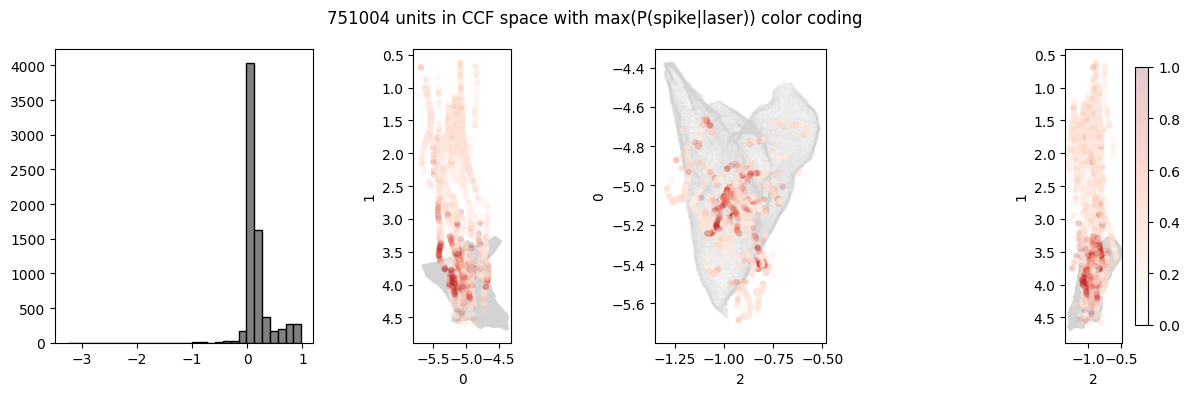

In [136]:

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
features = ['amp', 'firing_rate']
color_code_filtered = combined_tagged_units_filtered['p_max'].values
ax = axes[0]
# Plot histogram of color code
ax.hist(color_code_filtered[~np.isnan(color_code_filtered)], bins=30, color='gray', edgecolor='black')
# top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
# bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
# ax.axvline(top_90, color='red', linestyle='--', linewidth=1)
# ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
color_code_nl = color_code_filtered.copy()
color_code_nl = (color_code_nl - 0) / (np.nanmax(color_code_filtered)-0)  # Normalize color code to [0, 1] using 10-90% quantiles
color_code_nl[color_code_nl < 0] = 0
color_code_nl[color_code_nl > 1] = 1
x_ccf = combined_tagged_units_filtered['x_ccf'].values
y_ccf = combined_tagged_units_filtered['y_ccf'].values
z_ccf = combined_tagged_units_filtered['z_ccf'].values
ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
for plane, ax in zip(planes.keys(), axes[1:]):
    # Plot the mesh
    ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    # Plot the points
    sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=color_code_nl, cmap='Reds', s=20, edgecolor='none', alpha=0.2)
    # if plane == 'hor':
    #     ax.set_title(feature)
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    # set equal aspect ratio
    ax.set_aspect('equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'cor':
        fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.suptitle(f'{animal_id} units in CCF space with max(P(spike|laser)) color coding')
plt.tight_layout()
plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_units_ccf_opto_tag.png', dpi=300)

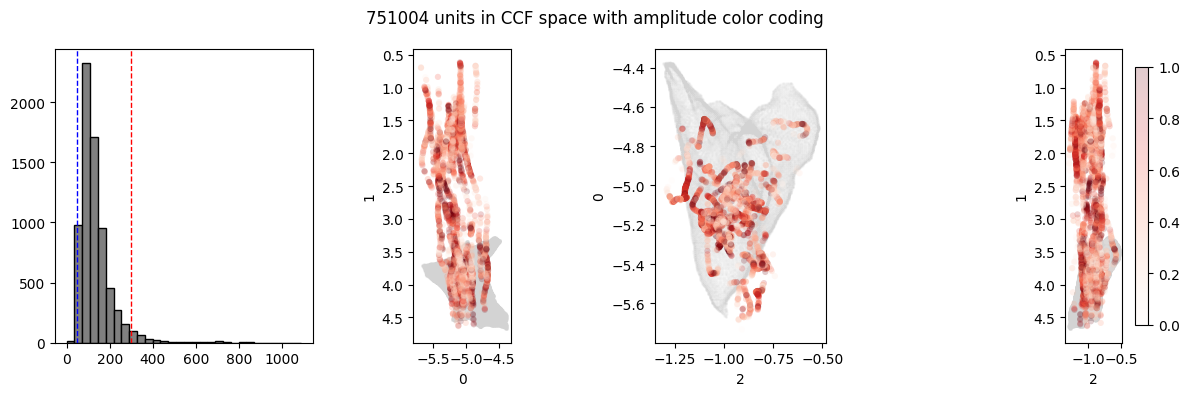

In [137]:

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
features = ['amp', 'firing_rate']
color_code_filtered = combined_tagged_units_filtered['amp'].values
ax = axes[0]
# Plot histogram of color code
ax.hist(color_code_filtered[~np.isnan(color_code_filtered)], bins=30, color='gray', edgecolor='black')
# top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
# bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
# ax.axvline(top_90, color='red', linestyle='--', linewidth=1)
# ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
color_code_nl = color_code_filtered.copy()
color_code_nl = (color_code_nl - 50) / (200-50)  # Normalize color code to [0, 1] using 10-90% quantiles
color_code_nl[color_code_nl < 0] = 0
color_code_nl[color_code_nl > 1] = 1
ax.axvline(50, color='blue', linestyle='--', linewidth=1)
ax.axvline(300, color='red', linestyle='--', linewidth=1)
x_ccf = combined_tagged_units_filtered['x_ccf'].values
y_ccf = combined_tagged_units_filtered['y_ccf'].values
z_ccf = combined_tagged_units_filtered['z_ccf'].values
ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
for plane, ax in zip(planes.keys(), axes[1:]):
    # Plot the mesh
    ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    # Plot the points
    sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=color_code_nl, cmap='Reds', s=20, edgecolor='none', alpha=0.2)
    # if plane == 'hor':
    #     ax.set_title(feature)
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    # set equal aspect ratio
    ax.set_aspect('equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'cor':
        fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.suptitle(f'{animal_id} units in CCF space with amplitude color coding')
plt.tight_layout()

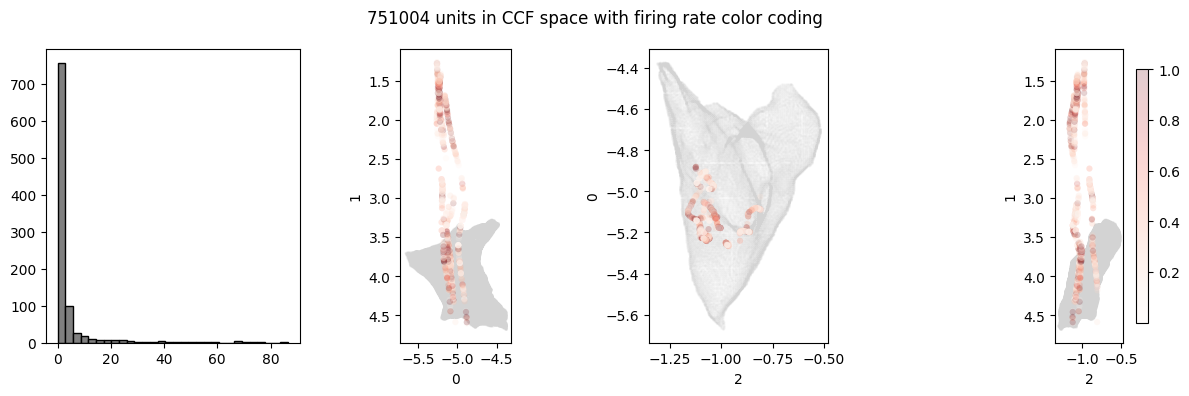

In [134]:

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
features = ['amp', 'firing_rate']
color_code_filtered = combined_tagged_units_filtered['fr'].values
ax = axes[0]
# Plot histogram of color code
ax.hist(color_code_filtered[~np.isnan(color_code_filtered)], bins=30, color='gray', edgecolor='black')
# top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
# bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
# ax.axvline(top_90, color='red', linestyle='--', linewidth=1)
# ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
color_code_nl = color_code_filtered.copy()
color_code_nl = (color_code_nl - 0) / (10)  # Normalize color code to [0, 1] using 10-90% quantiles
color_code_nl[color_code_nl < 0] = 0
color_code_nl[color_code_nl > 1] = 1
x_ccf = combined_tagged_units_filtered['x_ccf'].values
y_ccf = combined_tagged_units_filtered['y_ccf'].values
z_ccf = combined_tagged_units_filtered['z_ccf'].values
ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
for plane, ax in zip(planes.keys(), axes[1:]):
    # Plot the mesh
    ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    # Plot the points
    sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=color_code_nl, cmap='Reds', s=20, edgecolor='none', alpha=0.2)
    # if plane == 'hor':
    #     ax.set_title(feature)
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    # set equal aspect ratio
    ax.set_aspect('equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'cor':
        fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.suptitle(f'{animal_id} units in CCF space with firing rate color coding')
plt.tight_layout()